In [1]:
import gym
import numpy as np
import time

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
from torch.nn import functional as F

In [3]:
def discretize(min, max, num):
    return np.linspace(min, max, num + 1)[1:-1]

In [4]:
def digitize_state(observation, fineness):
    cart_x, cart_v, pole_th, pole_v = observation
    digitized_state = [
        np.digitize(cart_x,  bins=discretize(-2.4, 2.4, fineness)),
        np.digitize(cart_v,  bins=discretize(-3.0, 3.0, fineness)),
        np.digitize(pole_th, bins=discretize(-0.5, 0.5, fineness)),
        np.digitize(pole_v,  bins=discretize(-2.0, 2.0, fineness))
    ]
    return sum([x * (fineness**i) for i, x in enumerate(digitized_state)])

In [5]:
def update_qtable(q_table, current_status, action, next_status, current_reward):
    epsilon = 0.5
    next_reward = np.max(q_table[next_status])
    q_table[current_status, action] = (1 - epsilon) * q_table[current_status, action] + \
                                        epsilon * (current_reward + next_reward)
    return q_table

In [6]:
def calc_action(status, q_table):
    return 0 if q_table[status][0] > q_table[status][1] else 1

In [7]:
def calc_reward(observation, done, current_step, max_steps):
    if done:
        return 200 if current_step + 1 == max_steps else -200
    else:
        return 10 - sum([abs(observation[0]), abs(observation[1]), abs(observation[2]), abs(observation[3])])

In [8]:
def gen_model(env_name):
    env = gym.make(env_name)
    
    class QNetwork(nn.Module):
        def __init__(self):
            super(QNetwork, self).__init__()
            self.fc1 = nn.Linear(env.observation_space.shape[0], 16)
            self.fc2 = nn.Linear(16, env.action_space.n)
            
        def forward(self, x):
            x = Variable(x)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x
        
    return QNetwork().eval()

In [12]:
episode_rewards = []

def main():
    FINENESS = 8
    EPISODES  = 10
    MAX_STEPS = 10
      
    env = gym.make('CartPole-v1')
    q_table = np.random.rand(FINENESS**env.observation_space.shape[0], env.action_space.n)
    model = gen_model('CartPole-v1')
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    for episode in range(EPISODES):
        observation = env.reset()
        episode_reward = 0
        
        for step in range(MAX_STEPS):
            # do action     
            input_tensor = torch.tensor(observation, dtype=torch.float)
            y = model(input_tensor)
            action = np.argmax(y.detach().numpy())         
            observation, reward, done, info = env.step(action)
            
            # calc reward
            reward = calc_reward(observation, done, step, MAX_STEPS)
            episode_reward += reward
            
            # update model
            
            # render
            if (episode + 1) % 100 == 0:
                env.render()
                time.sleep(0.01)
            
            if done:
                break
#         print("episode_reward: {}".format(episode_reward))
        episode_rewards.append(episode_reward)
        
    env.close()

main()

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

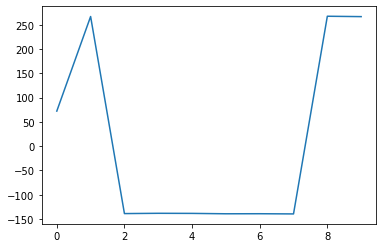

In [14]:
x = np.arange(len(episode_rewards))
y = np.array(episode_rewards)

plt.plot(x, y)
plt.show()